In [7]:
import time
import numpy as np
from numpy import mean, std, dstack
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, matthews_corrcoef
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D, Dropout, InputLayer
from tensorflow.keras.callbacks import History
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Layer
import xlsxwriter
from tensorflow.keras.regularizers import l2
from keras import layers
import keras
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

In [8]:
class Time2Vec(Layer):
    def __init__(self, kernel_size=1):
        super(Time2Vec, self).__init__()
        self.k = kernel_size

    def build(self, input_shape):
        self.w0 = self.add_weight(name="w0", shape=(1,), initializer="uniform", trainable=True)
        self.b0 = self.add_weight(name="b0", shape=(1,), initializer="uniform", trainable=True)
        self.w = self.add_weight(name="w", shape=(input_shape[-1], self.k), initializer="uniform", trainable=True)
        self.b = self.add_weight(name="b", shape=(self.k,), initializer="uniform", trainable=True)

    def call(self, inputs):
        v1 = self.w0 * inputs + self.b0
        v2 = tf.math.sin(tf.matmul(inputs, self.w) + self.b)
        return tf.concat([v1, v2], axis=-1)

In [9]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [10]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_classes,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv1D(filters=64, kernel_size=8, activation='relu', bias_regularizer='l2')(inputs)
    x = layers.MaxPooling1D(pool_size=17,strides=9)(x)
    x = Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)

    x = Time2Vec()(x)

    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)


In [11]:
def evaluate_model(trainX, trainy, testX, testy, sujet):
    verbose, epochs, batch_size = 1, 200, 64
    # Extract dimensions from training data:
    n_timesteps = trainX.shape[1]
    d_model= trainX.shape[2]  # This is 12 in your case
    n_outputs = trainy.shape[1]

    print("Train Data Shape:", trainX.shape)  # (num_samples, sequence_length, 12)
    print("Test Data Shape:", testX.shape)

    # Build the classifier model using the raw input dimension and then projecting internally.
    model = build_model(
       input_shape=(n_timesteps, d_model),
       head_size=128,
       num_heads=12,
       num_classes=n_outputs,
       ff_dim=24,
       num_transformer_blocks=1,
       mlp_units=[128],
       mlp_dropout=0.4,
       dropout=0.25,
    )
    model.summary()

    # Compile the model with categorical crossentropy and Adam optimizer.
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.0001),
                  metrics=['accuracy'])


    # Train the model
    start = time.time()
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=[history])
    train_time = time.time() - start  # seconds

    # Save the model
    model.save('D:\Transformer-Based-approach-for-hand-gesture-recognition-through-EMG-signals\DB4\models\Transformer_model_' + str(sujet) + '.h5')

    # Evaluate on training data
    loss_train, accuracy_train = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=1)
    start = time.time()
    loss_test, accuracy_test = model.evaluate(testX, testy, batch_size=batch_size, verbose=1)
    test_time = time.time() - start  # seconds

    # Predict on test data and convert predictions to class indices
    y_pred = np.argmax(model.predict(testX), axis=-1)
    testy_indices = [np.argmax(y) for y in testy]

    return loss_train, accuracy_train, loss_test, accuracy_test, y_pred, testy_indices, train_time, test_time


def summarize_results(scores, losses):
    m, s = mean(scores), std(scores)
    mL, sL = mean(losses), std(losses)
    print('\nAccuracy: %.5f (+/-%.5f)' % (m, s))
    print('Loss: %.5f (+/-%.5f)' % (mL, sL))

def run_my_experiment(sujet):
    # Load data from MATLAB file; update the path as needed.
    data = loadmat(fr"D:\Transformer-Based-approach-for-hand-gesture-recognition-through-EMG-signals\DB4\data\normalized_data\DB4_s" + str(sujet) + "_E1_A1_150_100_N.mat")

    train_data = data['train_data']      # shape: (num_train_samples, sequence_length, d_model)
    train_labels = data['train_labels']    # shape: (num_train_samples, num_classes)
    test_data = data['test_data']          # shape: (num_test_samples, sequence_length, d_model)
    test_labels = data['test_labels']      # shape: (num_test_samples, num_classes)

    scores = list()
    losses = list()

    loss_train, score_train, loss_test, score_test, y_pred, testy, train_time, test_time = evaluate_model(
        train_data, train_labels, test_data, test_labels, sujet
    )

    print('>#%d: ' % (sujet))
    print('  train accuracy: %.5f' % (score_train))
    print('  train loss    : %.5f' % (loss_train))
    print('  test accuracy: %.5f' % (score_test))
    print('  test loss    : %.5f' % (loss_test))
    scores.append(score_test)
    losses.append(loss_test)
    summarize_results(scores, losses)

    return loss_train, score_train, loss_test, score_test, y_pred, testy, train_time, test_time


<>:37: SyntaxWarning: invalid escape sequence '\T'
<>:37: SyntaxWarning: invalid escape sequence '\T'
C:\Users\ycn\AppData\Local\Temp\ipykernel_10084\2599827625.py:37: SyntaxWarning: invalid escape sequence '\T'
  model.save('D:\Transformer-Based-approach-for-hand-gesture-recognition-through-EMG-signals\DB4\models\Transformer_model_' + str(sujet) + '.h5')


Train Data Shape: (1463, 300, 12)
Test Data Shape: (704, 300, 12)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 293, 64)   │      6,208 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 31, 64)    │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 31, 64)    │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_5[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_1         │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_1[0][0… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 31, 65)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_7[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 31, 24)    │      1,584 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 31, 24)    │          0 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 31, 65)    │      1,625 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_5[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_3[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 11)        │      1,419 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 423,900 (1.62 MB)

 Trainable params: 423,772 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 191ms/step - accuracy: 0.1168 - loss: 2.7432
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - accuracy: 0.1779 - loss: 2.3235
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 188ms/step - accuracy: 0.1733 - loss: 2.2879
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 188ms/step - accuracy: 0.2073 - loss: 2.2437
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 187ms/step - accuracy: 0.2062 - loss: 2.1950
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step - accuracy: 0.2874 - loss: 2.1040
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - accuracy: 0.2788 - loss: 2.0672
Epoch 8/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - accuracy: 0.3072 - loss: 1.9926
Epoch 9/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - accuracy: 0.3114 - loss: 1.9358
Epoch 10/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step - accuracy: 0.3843 - loss: 1.8419
Epoch 11/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - accuracy: 0.3988 - loss: 1.7687
Epoch 12/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.8909 - loss: 0.2991
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.6532 - loss: 1.1184
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
>#1: 
  train accuracy: 0.88722
  train loss    : 0.30801
  test accuracy: 0.67756
  test loss    : 1.03072

Accuracy: 0.67756 (+/-0.00000)
Loss: 1.03072 (+/-0.00000)


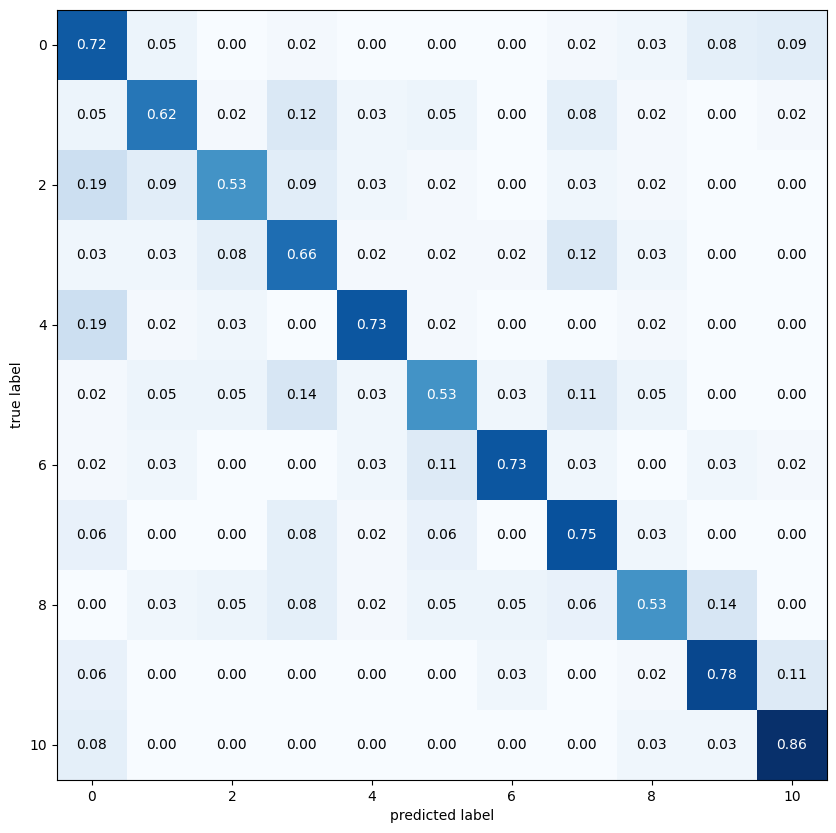

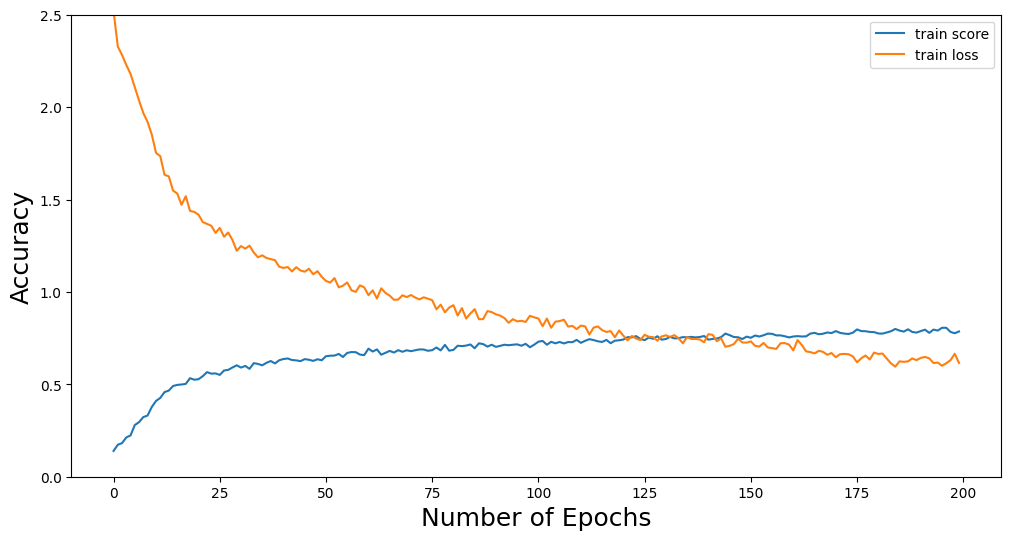

Train Data Shape: (1496, 300, 12)
Test Data Shape: (726, 300, 12)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 293, 64)   │      6,208 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 31, 64)    │          0 │ conv1d_6[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 31, 64)    │          0 │ max_pooling1d_2[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_10[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_2         │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_2[0][0… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_12[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 31, 24)    │      1,584 │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 31, 24)    │          0 │ conv1d_7[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 31, 65)    │      1,625 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_8[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_5[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 128)       │          0 │ dense_4[0][0]     │
│ (Dropout)           │                   │            │                 

 Total params: 423,900 (1.62 MB)

 Trainable params: 423,772 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 203ms/step - accuracy: 0.1058 - loss: 2.5989
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - accuracy: 0.1174 - loss: 2.4275
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 198ms/step - accuracy: 0.1211 - loss: 2.3920
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 188ms/step - accuracy: 0.1542 - loss: 2.3323
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - accuracy: 0.1771 - loss: 2.3043
Epoch 6/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - accuracy: 0.1924 - loss: 2.2729
Epoch 7/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - accuracy: 0.2304 - loss: 2.1816
Epoch 8/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - accuracy: 0.2525 - loss: 2.1065
Epoch 9/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 210ms/step - accuracy: 0.3103 - loss: 2.0381
Epoch 10/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 277ms/step - accuracy: 0.2923 - loss: 1.9362
Epoch 11/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 270ms/step - accuracy: 0.3130 - loss: 1.9053
Epoch 12/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.9699 - loss: 0.1173
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.6627 - loss: 1.2208
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
>#2: 
  train accuracy: 0.95388
  train loss    : 0.15493
  test accuracy: 0.65565
  test loss    : 1.22111

Accuracy: 0.65565 (+/-0.00000)
Loss: 1.22111 (+/-0.00000)


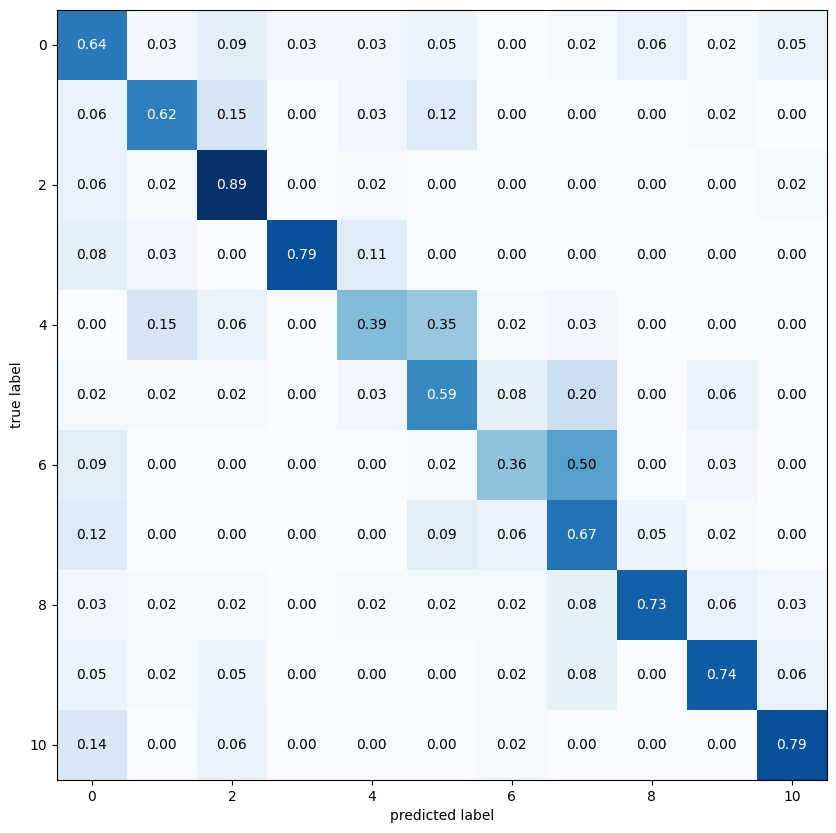

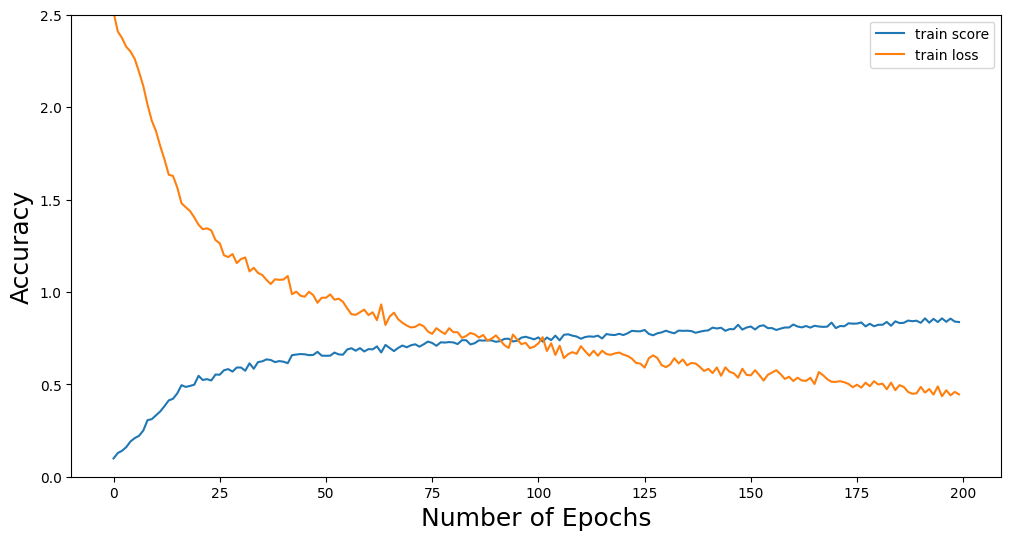

Train Data Shape: (1705, 300, 12)
Test Data Shape: (840, 300, 12)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 293, 64)   │      6,208 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 31, 64)    │          0 │ conv1d_9[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 31, 64)    │          0 │ max_pooling1d_3[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_15[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_3         │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_3[0][0… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_17[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 31, 24)    │      1,584 │ add_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 31, 24)    │          0 │ conv1d_10[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 31, 65)    │      1,625 │ dropout_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_11[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_7[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 128)       │          0 │ dense_6[0][0]     │
│ (Dropout)           │                   │            │                 

 Total params: 423,900 (1.62 MB)

 Trainable params: 423,772 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 192ms/step - accuracy: 0.0974 - loss: 2.5078
Epoch 2/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 194ms/step - accuracy: 0.1440 - loss: 2.3289
Epoch 3/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 197ms/step - accuracy: 0.1471 - loss: 2.2973
Epoch 4/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 194ms/step - accuracy: 0.1855 - loss: 2.2321
Epoch 5/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 192ms/step - accuracy: 0.2373 - loss: 2.1584
Epoch 6/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step - accuracy: 0.2952 - loss: 2.0345
Epoch 7/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - accuracy: 0.3026 - loss: 2.0091
Epoch 8/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 195ms/step - accuracy: 0.3341 - loss: 1.9219
Epoch 9/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 208ms/step - accuracy: 0.3507 - loss: 1.8449
Epoch 10/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 278ms/step - accuracy: 0.3904 - loss: 1.7990
Epoch 11/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 227ms/step - accuracy: 0.4011 - loss: 1.6953
Epoch 12/200
27/27 ━━━━━━━━━━━━━━━━

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.9220 - loss: 0.2480
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.5586 - loss: 1.6290
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step
>#3: 
  train accuracy: 0.91789
  train loss    : 0.25299
  test accuracy: 0.63452
  test loss    : 1.36619

Accuracy: 0.63452 (+/-0.00000)
Loss: 1.36619 (+/-0.00000)


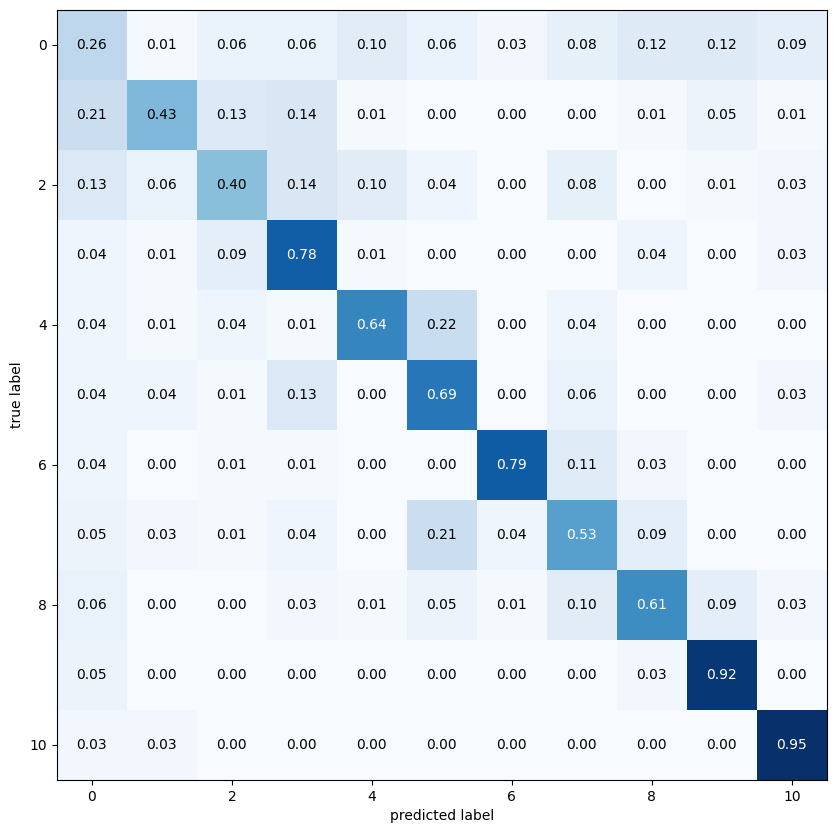

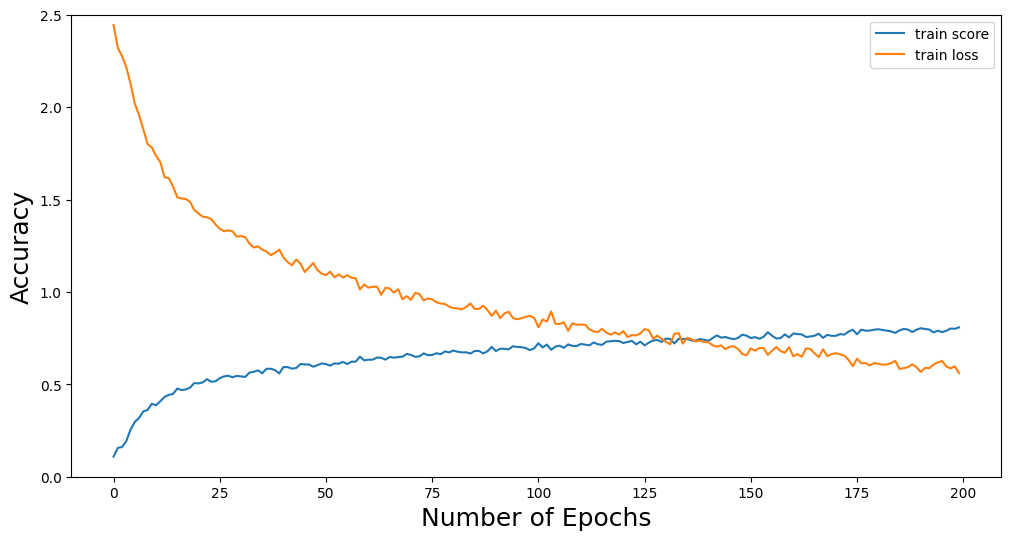

Train Data Shape: (913, 300, 12)
Test Data Shape: (479, 300, 12)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 293, 64)   │      6,208 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 31, 64)    │          0 │ conv1d_12[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 31, 64)    │          0 │ max_pooling1d_4[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_20[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_4         │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_4[0][0… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_22[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 31, 24)    │      1,584 │ add_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 31, 24)    │          0 │ conv1d_13[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 31, 65)    │      1,625 │ dropout_23[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_14[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_9[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 128)       │          0 │ dense_8[0][0]     │
│ (Dropout)           │                   │            │                 

 Total params: 423,900 (1.62 MB)

 Trainable params: 423,772 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 184ms/step - accuracy: 0.0977 - loss: 2.7013
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.1979 - loss: 2.2612
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - accuracy: 0.2592 - loss: 2.1415
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - accuracy: 0.2958 - loss: 2.0339
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step - accuracy: 0.3743 - loss: 1.8899
Epoch 6/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.4287 - loss: 1.7602
Epoch 7/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 190ms/step - accuracy: 0.4937 - loss: 1.5490
Epoch 8/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - accuracy: 0.4692 - loss: 1.5639
Epoch 9/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - accuracy: 0.5301 - loss: 1.4786
Epoch 10/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - accuracy: 0.5835 - loss: 1.3378
Epoch 11/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - accuracy: 0.5755 - loss: 1.3039
Epoch 12/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.9887 - loss: 0.0389
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.8222 - loss: 0.5021
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
>#4: 
  train accuracy: 0.98795
  train loss    : 0.04497
  test accuracy: 0.83925
  test loss    : 0.45165

Accuracy: 0.83925 (+/-0.00000)
Loss: 0.45165 (+/-0.00000)


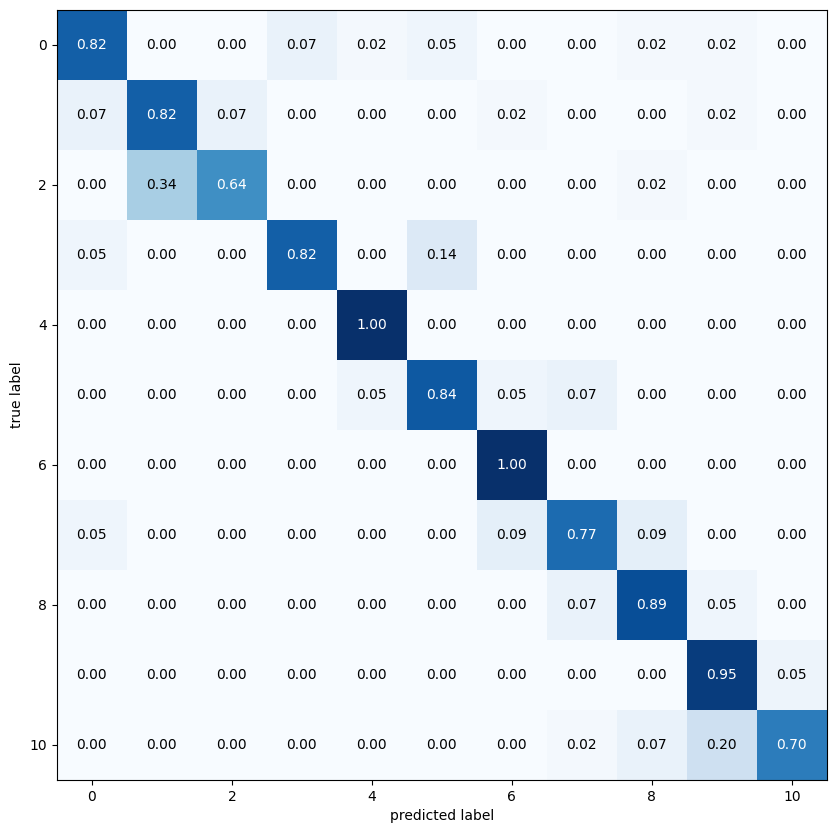

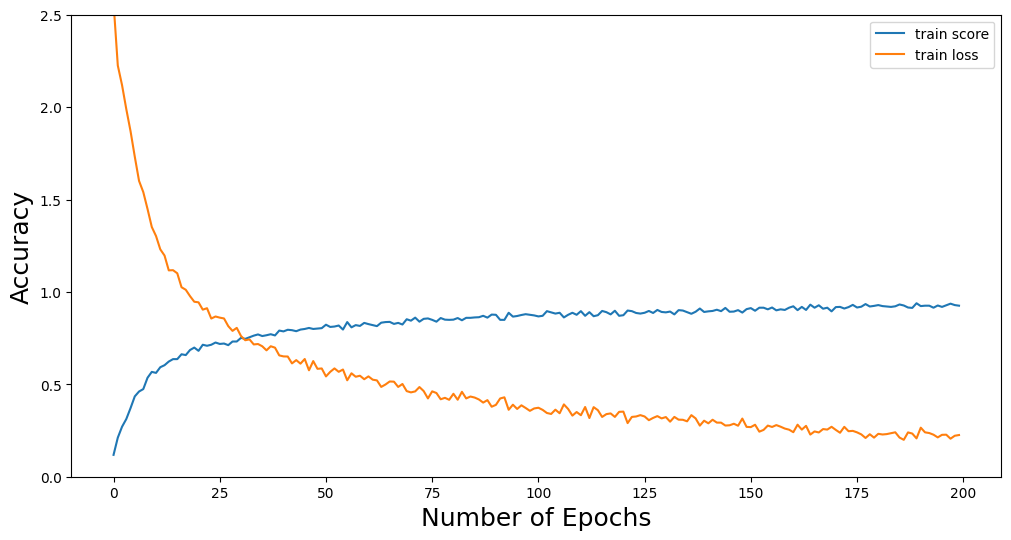

Train Data Shape: (1386, 300, 12)
Test Data Shape: (704, 300, 12)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 293, 64)   │      6,208 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 31, 64)    │          0 │ conv1d_15[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 31, 64)    │          0 │ max_pooling1d_5[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_25[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_5         │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_5[0][0… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_27[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 31, 24)    │      1,584 │ add_10[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 31, 24)    │          0 │ conv1d_16[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 31, 65)    │      1,625 │ dropout_28[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_17[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_11 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_10[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_11[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 128)       │          0 │ dense_10[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 423,900 (1.62 MB)

 Trainable params: 423,772 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 190ms/step - accuracy: 0.1591 - loss: 2.4780
Epoch 2/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step - accuracy: 0.2546 - loss: 2.1775
Epoch 3/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 190ms/step - accuracy: 0.2834 - loss: 2.0535
Epoch 4/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 190ms/step - accuracy: 0.3455 - loss: 1.9020
Epoch 5/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 188ms/step - accuracy: 0.3927 - loss: 1.8169
Epoch 6/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - accuracy: 0.4222 - loss: 1.7123
Epoch 7/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step - accuracy: 0.4332 - loss: 1.6684
Epoch 8/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - accuracy: 0.4477 - loss: 1.6548
Epoch 9/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step - accuracy: 0.4809 - loss: 1.6093
Epoch 10/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - accuracy: 0.4878 - loss: 1.5485
Epoch 11/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 199ms/step - accuracy: 0.5191 - loss: 1.4916
Epoch 12/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.9388 - loss: 0.2405
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.6351 - loss: 1.1791
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
>#5: 
  train accuracy: 0.94733
  train loss    : 0.20249
  test accuracy: 0.66619
  test loss    : 1.17043

Accuracy: 0.66619 (+/-0.00000)
Loss: 1.17043 (+/-0.00000)


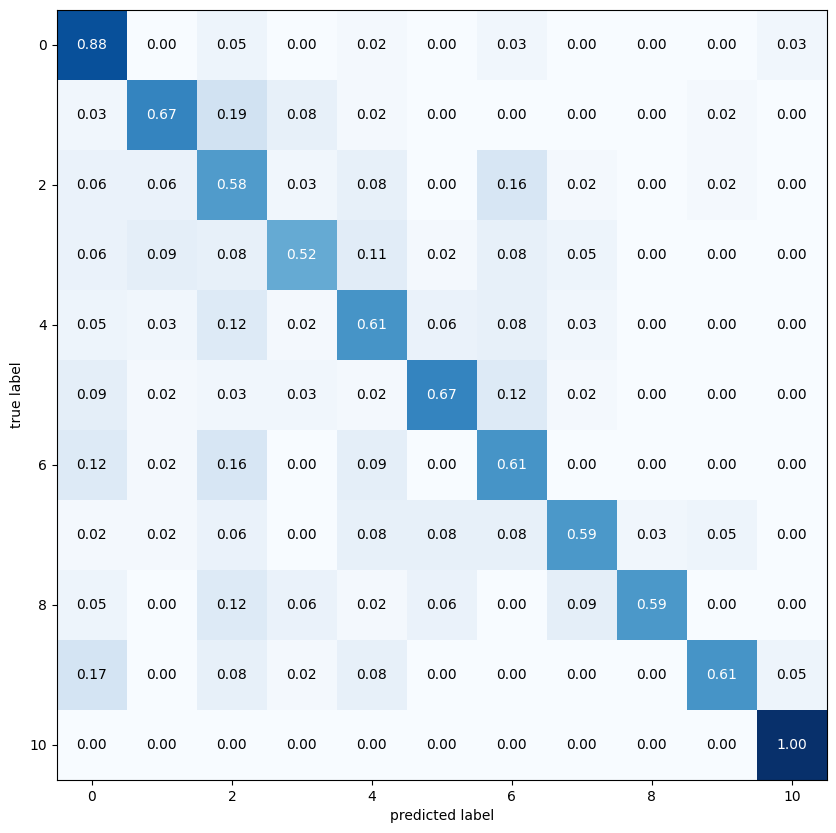

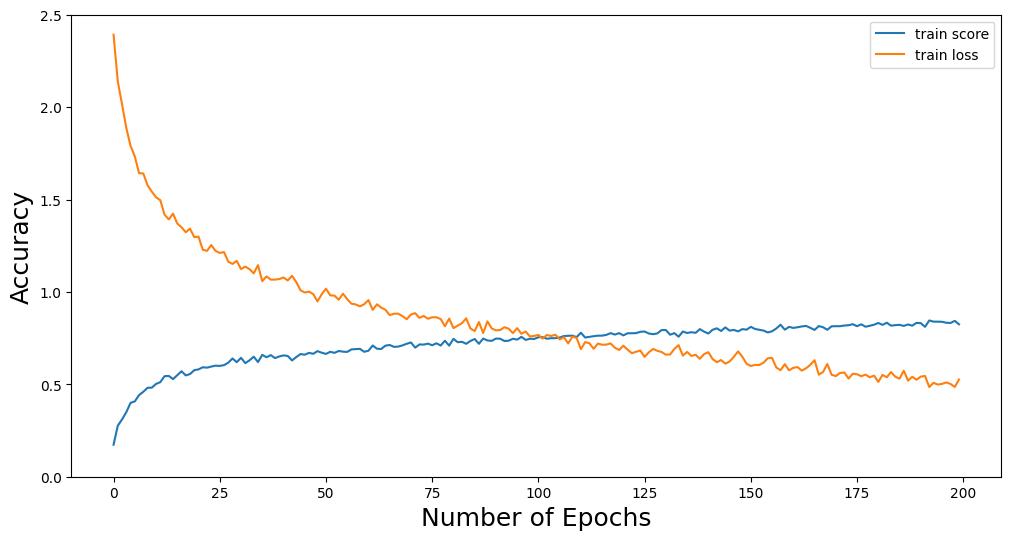

Train Data Shape: (970, 300, 12)
Test Data Shape: (480, 300, 12)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 293, 64)   │      6,208 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 31, 64)    │          0 │ conv1d_18[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 31, 64)    │          0 │ max_pooling1d_6[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_30[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_6         │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_6[0][0… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_32          │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_32[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, 31, 24)    │      1,584 │ add_12[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_33          │ (None, 31, 24)    │          0 │ conv1d_19[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_20 (Conv1D)  │ (None, 31, 65)    │      1,625 │ dropout_33[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_20[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_12[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_13[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_34          │ (None, 128)       │          0 │ dense_12[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 423,771 (1.62 MB)

 Trainable params: 423,643 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 195ms/step - accuracy: 0.1159 - loss: 2.4997
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - accuracy: 0.1560 - loss: 2.2496
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - accuracy: 0.1959 - loss: 2.1868
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - accuracy: 0.2151 - loss: 2.1274
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - accuracy: 0.2620 - loss: 2.0676
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 196ms/step - accuracy: 0.3022 - loss: 1.9641
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.3530 - loss: 1.8380
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - accuracy: 0.3711 - loss: 1.7549
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - accuracy: 0.4556 - loss: 1.6265
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.4691 - loss: 1.5293
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - accuracy: 0.4377 - loss: 1.5752
Epoch 12/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.9795 - loss: 0.0673
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.7834 - loss: 0.8867
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
>#6: 
  train accuracy: 0.98351
  train loss    : 0.05771
  test accuracy: 0.80417
  test loss    : 0.81785

Accuracy: 0.80417 (+/-0.00000)
Loss: 0.81785 (+/-0.00000)


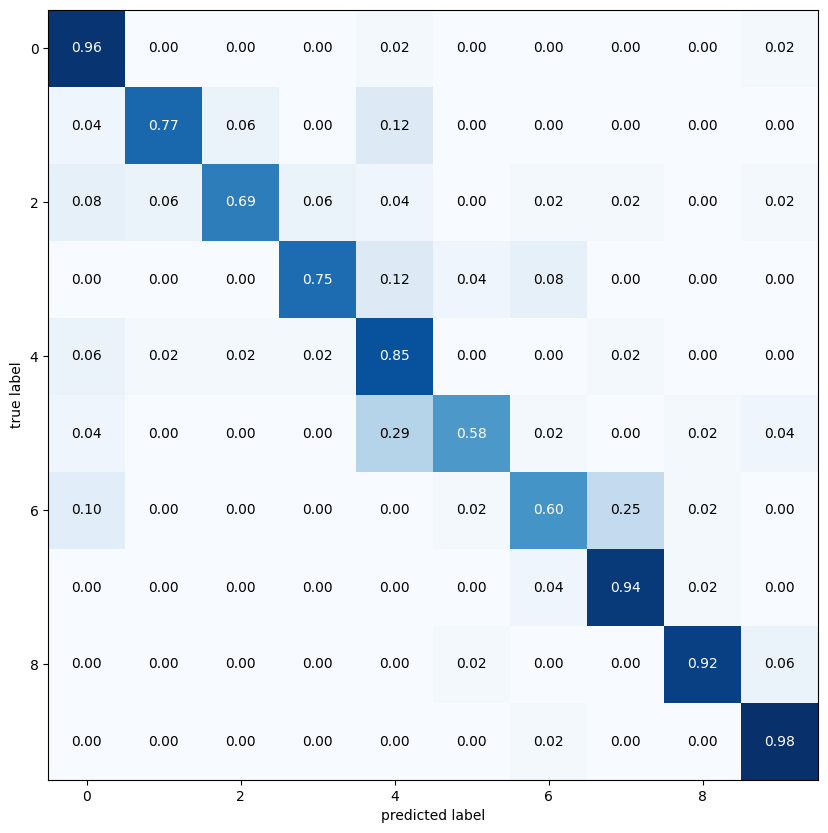

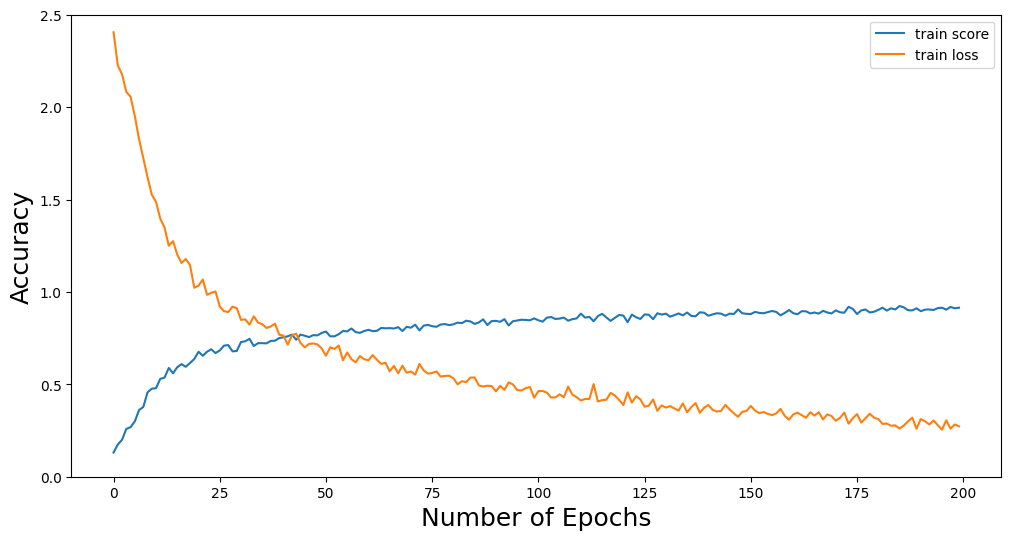

Train Data Shape: (1461, 300, 12)
Test Data Shape: (832, 300, 12)


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_21 (Conv1D)  │ (None, 293, 64)   │      6,208 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_7     │ (None, 31, 64)    │          0 │ conv1d_21[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_35          │ (None, 31, 64)    │          0 │ max_pooling1d_7[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_35[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_7         │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_7[0][0… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_37          │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_37[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_22 (Conv1D)  │ (None, 31, 24)    │      1,584 │ add_14[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_38          │ (None, 31, 24)    │          0 │ conv1d_22[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_23 (Conv1D)  │ (None, 31, 65)    │      1,625 │ dropout_38[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_23[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_15 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_14[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_15[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_39          │ (None, 128)       │          0 │ dense_14[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 423,900 (1.62 MB)

 Trainable params: 423,772 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - accuracy: 0.1197 - loss: 2.5145
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 191ms/step - accuracy: 0.1665 - loss: 2.2611
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step - accuracy: 0.1675 - loss: 2.2180
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step - accuracy: 0.1756 - loss: 2.1466
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - accuracy: 0.1955 - loss: 2.1181
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - accuracy: 0.2017 - loss: 2.1160
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 202ms/step - accuracy: 0.2194 - loss: 2.0623
Epoch 8/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 194ms/step - accuracy: 0.2195 - loss: 2.0719
Epoch 9/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step - accuracy: 0.2440 - loss: 1.9929
Epoch 10/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step - accuracy: 0.2631 - loss: 1.9709
Epoch 11/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 194ms/step - accuracy: 0.3133 - loss: 1.9230
Epoch 12/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.9210 - loss: 0.2559
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.5964 - loss: 1.4300
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
>#7: 
  train accuracy: 0.92676
  train loss    : 0.22696
  test accuracy: 0.62260
  test loss    : 1.54668

Accuracy: 0.62260 (+/-0.00000)
Loss: 1.54668 (+/-0.00000)


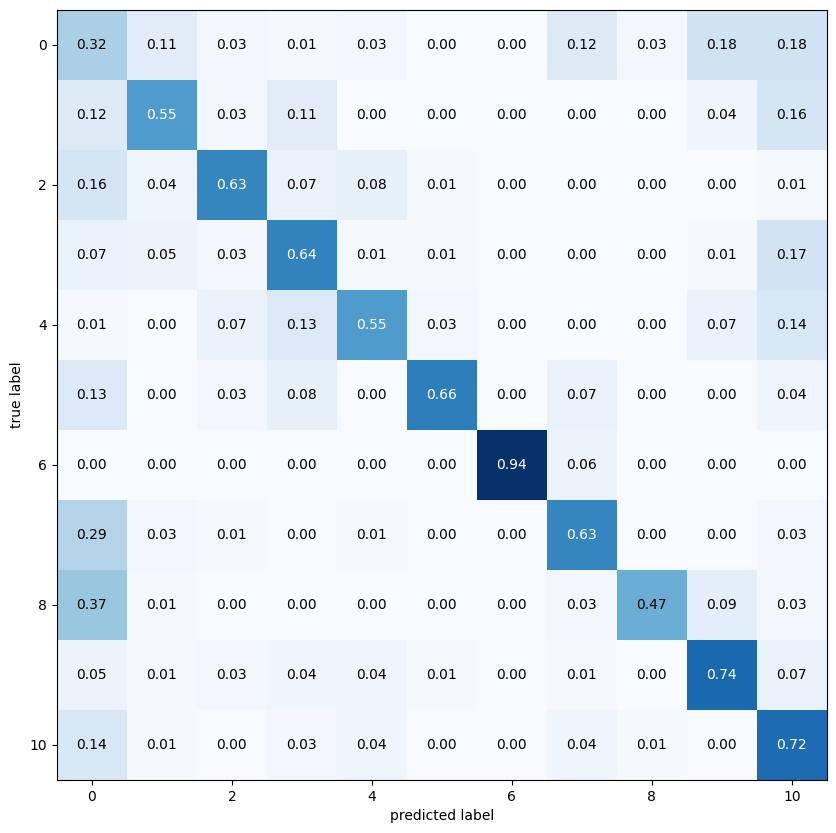

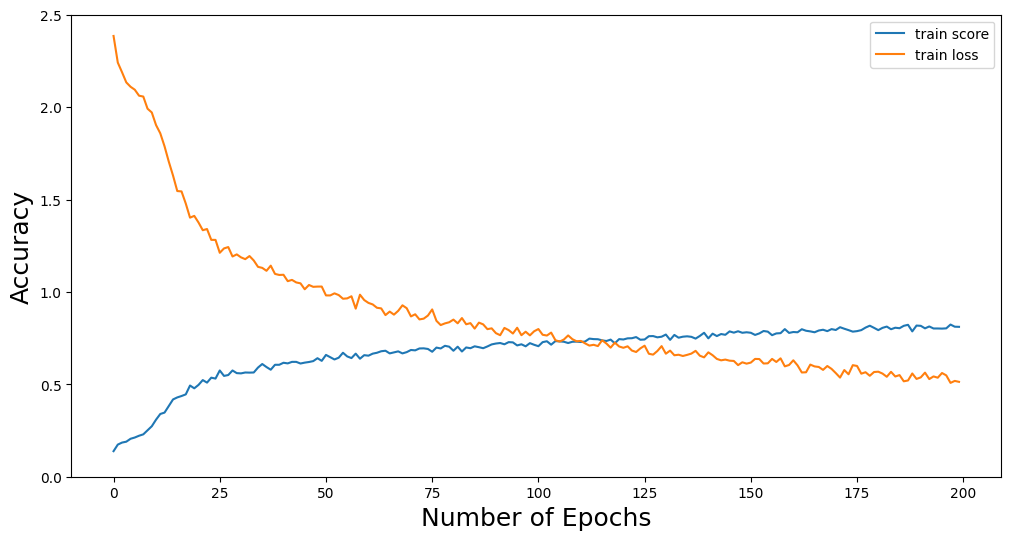

Train Data Shape: (1111, 300, 12)
Test Data Shape: (539, 300, 12)


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_24 (Conv1D)  │ (None, 293, 64)   │      6,208 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_8     │ (None, 31, 64)    │          0 │ conv1d_24[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_40          │ (None, 31, 64)    │          0 │ max_pooling1d_8[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_40[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_8         │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_8[0][0… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_8[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_42          │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_42[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_8[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_25 (Conv1D)  │ (None, 31, 24)    │      1,584 │ add_16[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_43          │ (None, 31, 24)    │          0 │ conv1d_25[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_26 (Conv1D)  │ (None, 31, 65)    │      1,625 │ dropout_43[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_26[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_16[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_17[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_44          │ (None, 128)       │          0 │ dense_16[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 423,900 (1.62 MB)

 Trainable params: 423,772 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 203ms/step - accuracy: 0.0994 - loss: 2.5907
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 203ms/step - accuracy: 0.1489 - loss: 2.3735
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - accuracy: 0.1946 - loss: 2.2924
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - accuracy: 0.1933 - loss: 2.2397
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - accuracy: 0.2224 - loss: 2.2078
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - accuracy: 0.1692 - loss: 2.2394
Epoch 7/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.2066 - loss: 2.1931
Epoch 8/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 200ms/step - accuracy: 0.2036 - loss: 2.2232
Epoch 9/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - accuracy: 0.2424 - loss: 2.1401
Epoch 10/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step - accuracy: 0.2307 - loss: 2.1695
Epoch 11/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - accuracy: 0.2487 - loss: 2.1164
Epoch 12/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.9480 - loss: 0.1401
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.7635 - loss: 0.9183
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
>#8: 
  train accuracy: 0.96580
  train loss    : 0.10755
  test accuracy: 0.80891
  test loss    : 0.71233

Accuracy: 0.80891 (+/-0.00000)
Loss: 0.71233 (+/-0.00000)


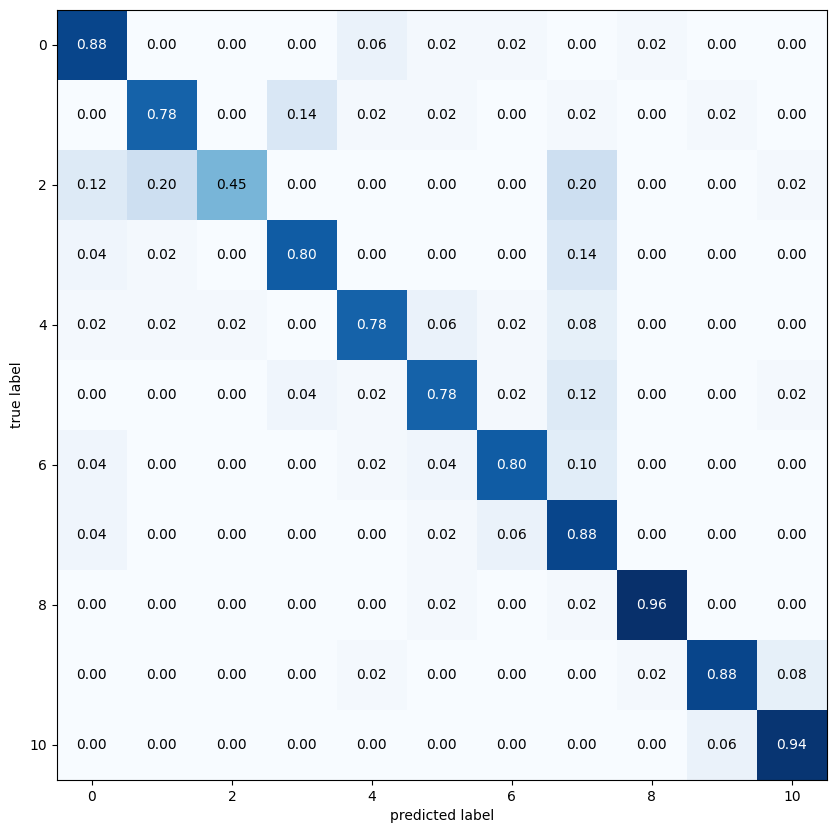

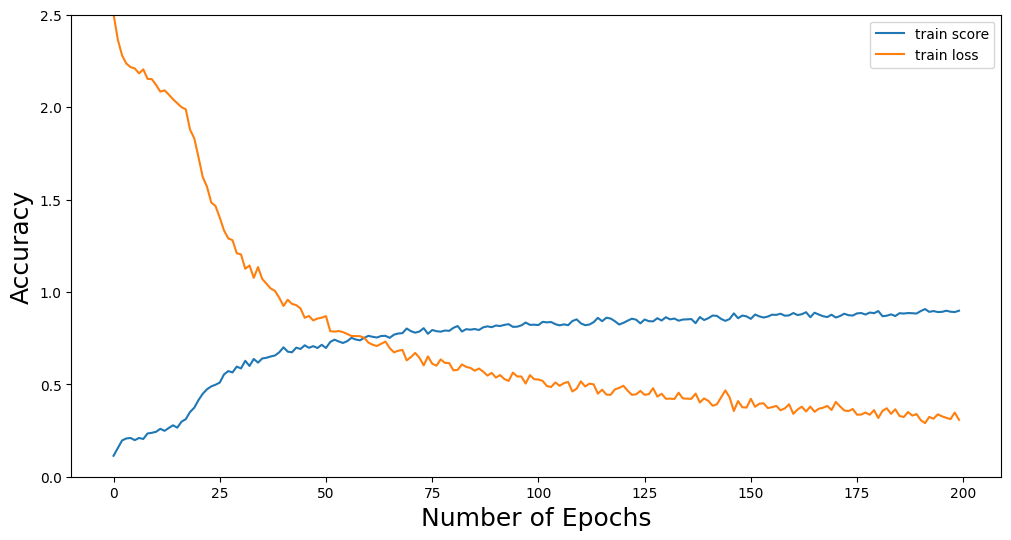

Train Data Shape: (1100, 300, 12)
Test Data Shape: (572, 300, 12)


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_27 (Conv1D)  │ (None, 293, 64)   │      6,208 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_9     │ (None, 31, 64)    │          0 │ conv1d_27[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_45          │ (None, 31, 64)    │          0 │ max_pooling1d_9[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_45[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_9         │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_9[0][0… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_9[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_47          │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_47[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_9[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_28 (Conv1D)  │ (None, 31, 24)    │      1,584 │ add_18[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_48          │ (None, 31, 24)    │          0 │ conv1d_28[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_29 (Conv1D)  │ (None, 31, 65)    │      1,625 │ dropout_48[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_29[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_19 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_18[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_19[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_49          │ (None, 128)       │          0 │ dense_18[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 423,900 (1.62 MB)

 Trainable params: 423,772 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 194ms/step - accuracy: 0.0889 - loss: 2.7598
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - accuracy: 0.1138 - loss: 2.4737
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step - accuracy: 0.1141 - loss: 2.4045
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.1303 - loss: 2.3623
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - accuracy: 0.1572 - loss: 2.2769
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - accuracy: 0.1982 - loss: 2.2216
Epoch 7/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 230ms/step - accuracy: 0.2190 - loss: 2.1914
Epoch 8/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 272ms/step - accuracy: 0.2365 - loss: 2.0813
Epoch 9/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 196ms/step - accuracy: 0.2019 - loss: 2.0577
Epoch 10/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - accuracy: 0.2434 - loss: 1.9749
Epoch 11/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.2943 - loss: 1.8704
Epoch 12/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.9801 - loss: 0.0794
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.7233 - loss: 0.9340
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
>#9: 
  train accuracy: 0.98000
  train loss    : 0.08194
  test accuracy: 0.74476
  test loss    : 0.92174

Accuracy: 0.74476 (+/-0.00000)
Loss: 0.92174 (+/-0.00000)


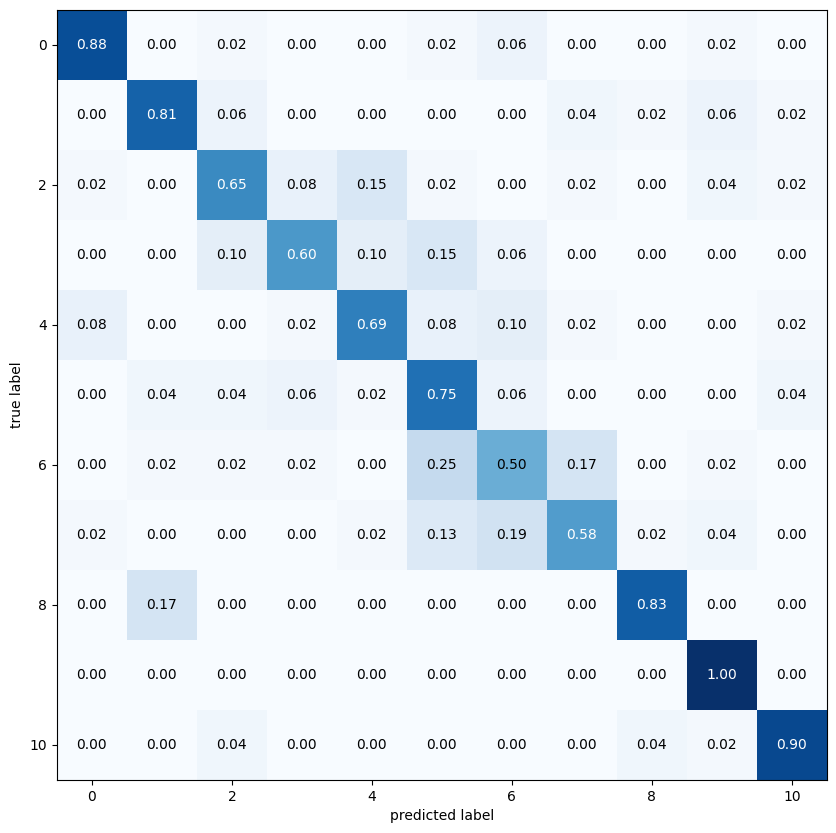

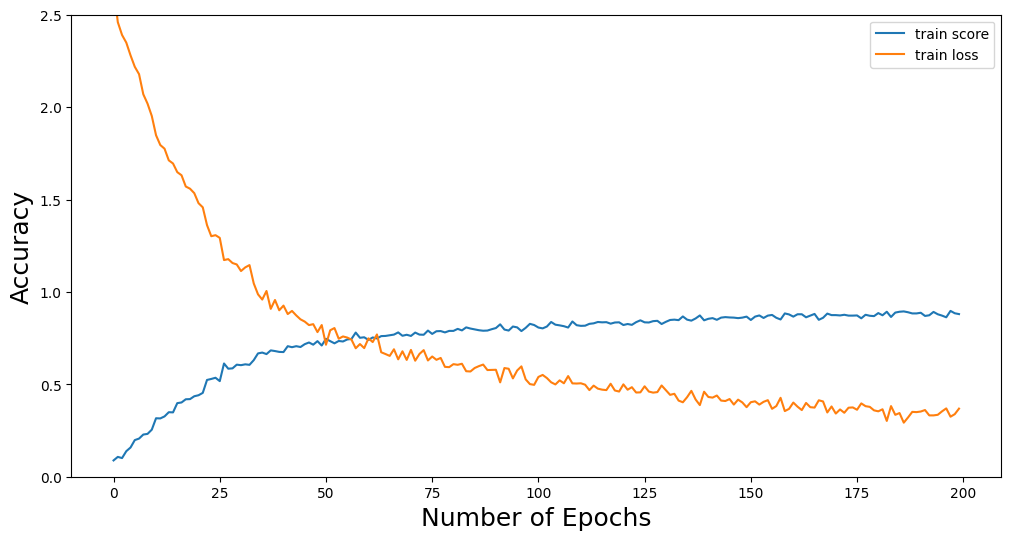

Train Data Shape: (1160, 300, 12)
Test Data Shape: (580, 300, 12)


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_30 (Conv1D)  │ (None, 293, 64)   │      6,208 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_10    │ (None, 31, 64)    │          0 │ conv1d_30[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_50          │ (None, 31, 64)    │          0 │ max_pooling1d_10… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_50[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_10        │ (None, 31, 65)    │         67 │ batch_normalizat… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 65)    │    404,033 │ time2_vec_10[0][… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_10[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_52          │ (None, 31, 65)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ dropout_52[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_20 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_10[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_31 (Conv1D)  │ (None, 31, 24)    │      1,584 │ add_20[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_53          │ (None, 31, 24)    │          0 │ conv1d_31[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_32 (Conv1D)  │ (None, 31, 65)    │      1,625 │ dropout_53[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 65)    │        130 │ conv1d_32[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_21 (Add)        │ (None, 31, 65)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_20[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 65)        │          0 │ add_21[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 128)       │      8,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_54          │ (None, 128)       │          0 │ dense_20[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 423,900 (1.62 MB)

 Trainable params: 423,772 (1.62 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 184ms/step - accuracy: 0.1052 - loss: 2.6904
Epoch 2/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step - accuracy: 0.1991 - loss: 2.2526
Epoch 3/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 191ms/step - accuracy: 0.2775 - loss: 2.1159
Epoch 4/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step - accuracy: 0.2560 - loss: 2.0579
Epoch 5/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step - accuracy: 0.3347 - loss: 1.9442
Epoch 6/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - accuracy: 0.3650 - loss: 1.8851
Epoch 7/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 191ms/step - accuracy: 0.4263 - loss: 1.7894
Epoch 8/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - accuracy: 0.4013 - loss: 1.7780
Epoch 9/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step - accuracy: 0.4148 - loss: 1.7250
Epoch 10/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - accuracy: 0.4698 - loss: 1.6436
Epoch 11/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step - accuracy: 0.4405 - loss: 1.6365
Epoch 12/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.9599 - loss: 0.1433
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.7870 - loss: 0.7162
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
>#10: 
  train accuracy: 0.96897
  train loss    : 0.11932
  test accuracy: 0.78448
  test loss    : 0.73838

Accuracy: 0.78448 (+/-0.00000)
Loss: 0.73838 (+/-0.00000)


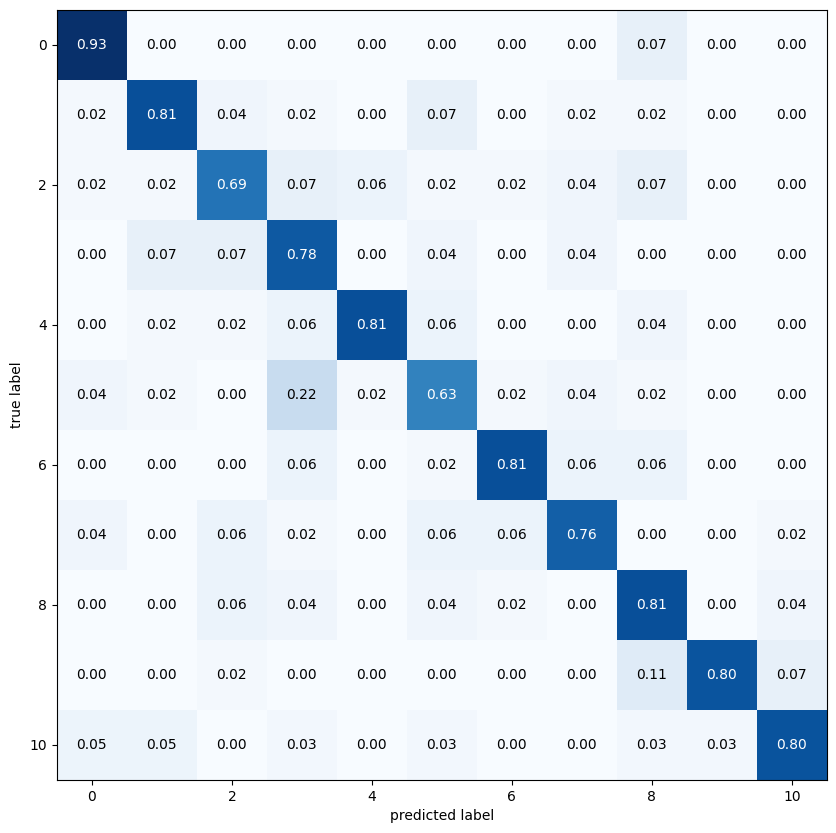

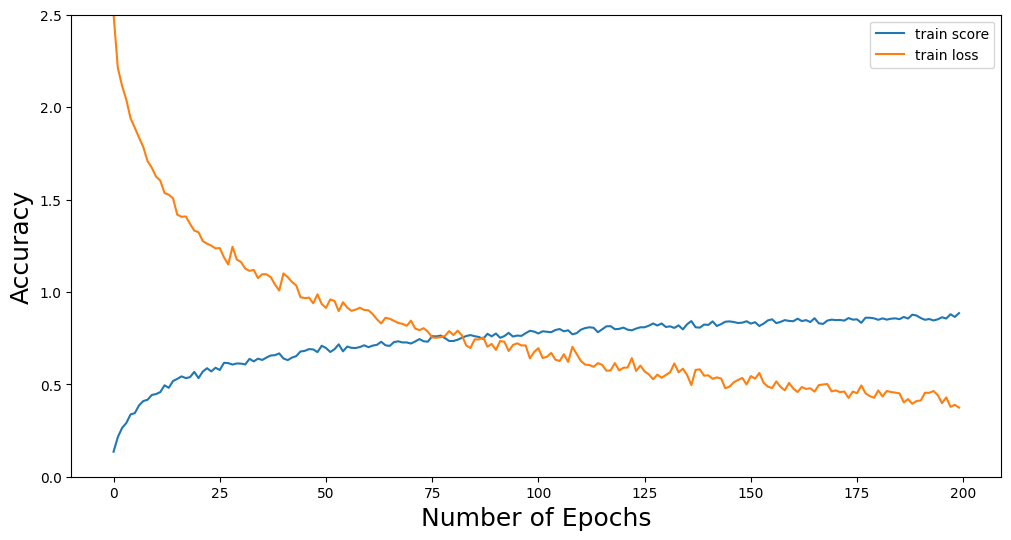

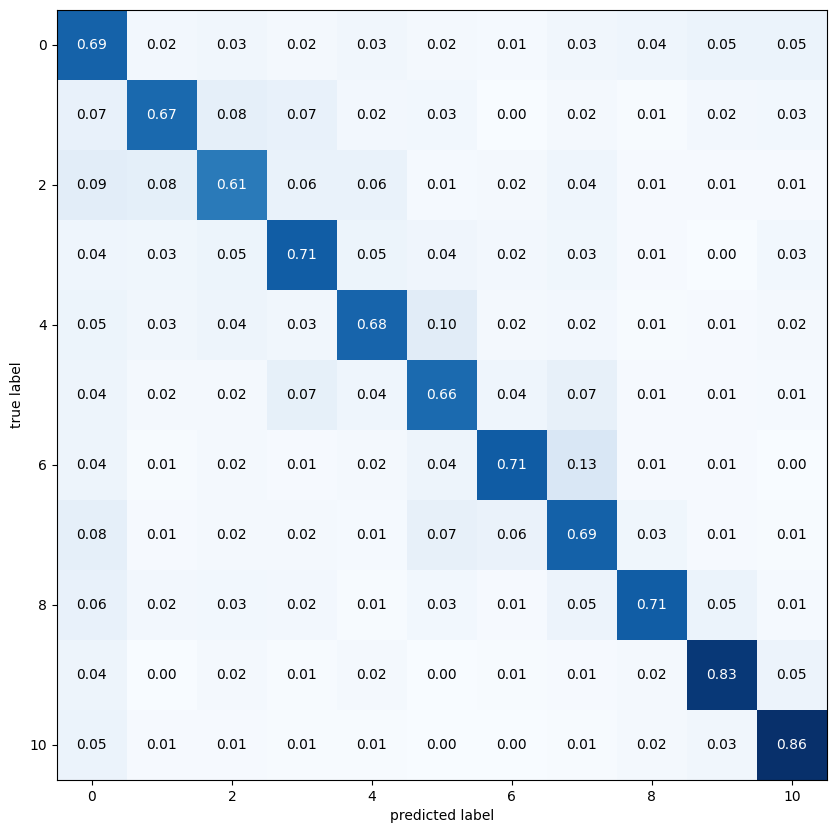

In [12]:

# Main
# ==============================================================================

globel_perd = []
globel_class = []

globel_perd1 = []
globel_class1 = []

# Create a workbook and add a worksheet.
workbook = xlsxwriter.Workbook(fr'D:\Transformer-Based-approach-for-hand-gesture-recognition-through-EMG-signals\DB4\results\v1\xlsx\Trans_DB4_rslt.xlsx')
worksheet1 = workbook.add_worksheet('Subjects informations')

# Start from the first cell. Rows and columns are zero indexed.
row = 0

worksheet1.write(row, 0, 'Subject')
worksheet1.write(row, 1, 'Train_time')
worksheet1.write(row, 2, 'Test_time')
worksheet1.write(row, 3, 'Train_acc')
worksheet1.write(row, 4, 'Train_loss')
worksheet1.write(row, 5, 'Test_acc')
worksheet1.write(row, 6, 'Test_loss')
worksheet1.write(row, 7, 'MCC')

history = History()
for i in range(1, 11):
    loss_train, score_train, loss_test, score_test, y_pred, testy, train_time, test_time = run_my_experiment(i)

    globel_perd.append(y_pred)
    globel_class.append(testy)

    globel_perd1.extend(y_pred)
    globel_class1.extend(testy)

    mcc = matthews_corrcoef(testy, y_pred)
    mat = confusion_matrix(testy, y_pred)

    cfm_plot, ax = plot_confusion_matrix(mat, figsize=(10, 10), show_normed=True, show_absolute=False)
    cfm_plot.savefig(fr'D:\Transformer-Based-approach-for-hand-gesture-recognition-through-EMG-signals\DB4\results\v1\confusion_matrix\DB4_s' + str(i) + 'trans_confusion_matrix.png')

    fig, axarr = plt.subplots(figsize=(12, 6), ncols=1)
    plot_renge = int(len(history.history['accuracy']) / i)
    global_renge = len(history.history['accuracy'])
    start_renge = global_renge - plot_renge
    axarr.plot(range(plot_renge), history.history['accuracy'][start_renge: global_renge], label='train score')
    axarr.plot(range(plot_renge), history.history['loss'][start_renge: global_renge], label='train loss')
    axarr.set_xlabel('Number of Epochs', fontsize=18)
    axarr.set_ylabel('Accuracy', fontsize=18)
    axarr.set_ylim([0, 2.5])
    plt.legend()
    plt.show()
    fig.savefig(fr'D:\Transformer-Based-approach-for-hand-gesture-recognition-through-EMG-signals\DB4\results\v1\graphs\DB4_s' + str(i) + 'trans_graphe.png')

    # Sheet informations
    worksheet1.write(i, 0, 'Sujet ' + str(i))
    worksheet1.write(i, 1, train_time)
    worksheet1.write(i, 2, test_time)
    worksheet1.write(i, 3, score_train)
    worksheet1.write(i, 4, loss_train)
    worksheet1.write(i, 5, score_test)
    worksheet1.write(i, 6, loss_test)
    worksheet1.write(i, 7, mcc)

workbook.close()

# Save prediction
new_data = {'pred_labels': globel_perd, 'class_labels': globel_class}
savemat(fr'D:\Transformer-Based-approach-for-hand-gesture-recognition-through-EMG-signals\DB4\results\v1\general_results\trans_global_predection.mat', new_data)

mat = confusion_matrix(globel_class1, globel_perd1)
cfm_plot, ax = plot_confusion_matrix(mat, figsize=(10, 10), show_normed=True, show_absolute=False)
cfm_plot.savefig(fr'D:\Transformer-Based-approach-for-hand-gesture-recognition-through-EMG-signals\DB4\results\v1\general_results\trans_global_confusion_matrix.png')


